In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [24]:
# Загрузка таблиц
df_sample = pd.read_csv("sample.tsv", sep="\t")
df_portion = pd.read_csv("portion.tsv", sep="\t")
df_analyte = pd.read_csv("analyte.tsv", sep="\t")
df_aliquot = pd.read_csv("aliquot.tsv", sep="\t")

In [25]:
# Подсчёт количества элементов на sample_id
portions_per_sample = df_portion["samples.sample_id"].value_counts()
analytes_per_sample = df_analyte["samples.sample_id"].value_counts()
aliquots_per_sample = df_aliquot["samples.sample_id"].value_counts()

In [26]:
# Объединение в метрики
sample_metrics = pd.DataFrame({
    "portions_count": portions_per_sample,
    "analytes_count": analytes_per_sample,
    "aliquots_count": aliquots_per_sample
}).fillna(0).astype(int)

In [27]:
# Добавление типа образца и ткани
sample_info = df_sample.set_index("samples.sample_id")[["samples.sample_type", "samples.tissue_type"]]
sample_analysis_df = sample_metrics.join(sample_info)

In [28]:
# Создание подтаблиц
metastatic = sample_analysis_df[sample_analysis_df["samples.sample_type"] == "Metastatic"]
normal = sample_analysis_df[sample_analysis_df["samples.sample_type"] == "Blood Derived Normal"]

In [29]:
# Проведение тестов Манна-Уитни
test_results = {
    "portions": mannwhitneyu(metastatic["portions_count"], normal["portions_count"], alternative='two-sided'),
    "analytes": mannwhitneyu(metastatic["analytes_count"], normal["analytes_count"], alternative='two-sided'),
    "aliquots": mannwhitneyu(metastatic["aliquots_count"], normal["aliquots_count"], alternative='two-sided'),
}

In [30]:
# Вывод p-значений
for key, result in test_results.items():
    print(f"{key}: U={result.statistic:.2f}, p-value={result.pvalue:.4f}")

portions: U=10150.50, p-value=0.0000
analytes: U=10150.50, p-value=0.0000
aliquots: U=10150.50, p-value=0.0000


<ipython-input-64-bd4cc0f62dfc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sample_analysis_df, x="samples.sample_type", y=feature, errorbar='sd', palette=colors)
<ipython-input-64-bd4cc0f62dfc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sample_analysis_df, x="samples.sample_type", y=feature, errorbar='sd', palette=colors)
<ipython-input-64-bd4cc0f62dfc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sample_analysis_df, x="samples.sample_type", y=feature, errorbar='sd', palette=colors)


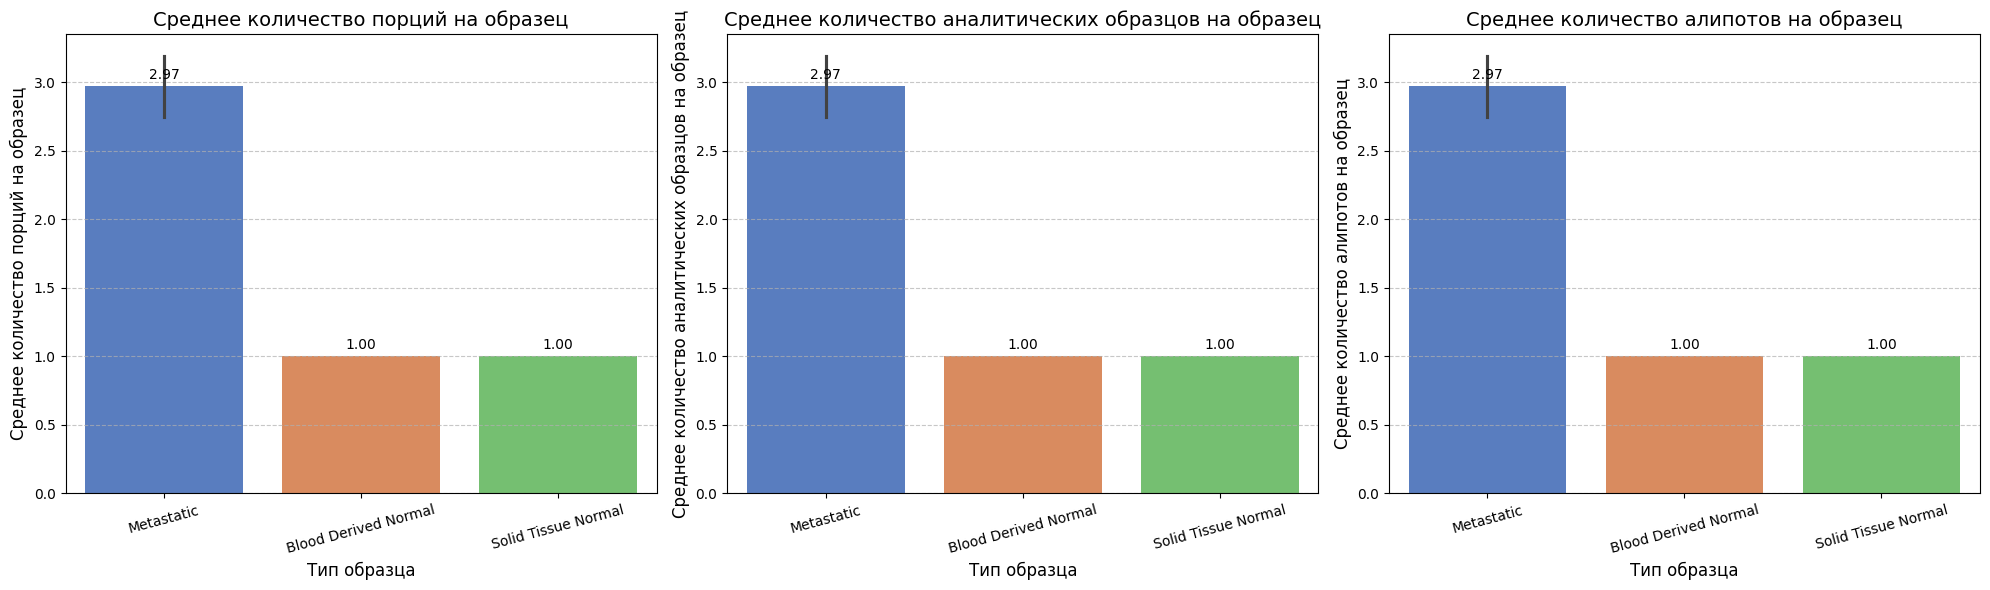

In [64]:
plt.figure(figsize=(20, 6))  # Размер графиков

titles = {
    "portions_count": "Среднее количество порций на образец",
    "analytes_count": "Среднее количество аналитических образцов на образец",
    "aliquots_count": "Среднее количество алипотов на образец"
}

colors = sns.color_palette("muted", 3)  # Мягкие цвета для каждого графика

for i, feature in enumerate(titles.keys()):
    plt.subplot(1, 3, i + 1)
    ax = sns.barplot(data=sample_analysis_df, x="samples.sample_type", y=feature, errorbar='sd', palette=colors)

    # Настроим стиль графиков для лучшей читаемости
    plt.title(f"{titles[feature]}", fontsize=14)
    plt.xlabel("Тип образца", fontsize=12)
    plt.ylabel(f"{titles[feature]}", fontsize=12)
    plt.xticks(rotation=15, fontsize=10)

    # Добавим сетку для удобства восприятия
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Аннотации
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    fontsize=10, color='black',
                    xytext=(0, 8), textcoords='offset points')

# Изменяем расстояние между графиками
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # wspace — горизонтальное, hspace — вертикальное расстояние
plt.tight_layout()
plt.show()


In [43]:
from scipy.stats import mannwhitneyu

In [44]:
# Оставим только metastatic и blood normal (их по 101)
metastatic = sample_analysis_df[sample_analysis_df["samples.sample_type"] == "Metastatic"]
normal = sample_analysis_df[sample_analysis_df["samples.sample_type"] == "Blood Derived Normal"]

In [45]:
# Проведем тесты
test_results = {
    "portions": mannwhitneyu(metastatic["portions_count"], normal["portions_count"], alternative='two-sided'),
    "analytes": mannwhitneyu(metastatic["analytes_count"], normal["analytes_count"], alternative='two-sided'),
    "aliquots": mannwhitneyu(metastatic["aliquots_count"], normal["aliquots_count"], alternative='two-sided'),
}

In [46]:
# Вывод
for key, result in test_results.items():
    print(f"{key}: U={result.statistic:.2f}, p-value={result.pvalue:.5f}")

portions: U=10150.50, p-value=0.00000
analytes: U=10150.50, p-value=0.00000
aliquots: U=10150.50, p-value=0.00000
